In [1]:
from PIL import Image, ImageChops, ImageDraw
import random, numpy as np
import fitz

def load_pdf(im):
    doc = fitz.open(im)
    page = doc[0]
    zoom = 1
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)
    return Image.frombytes('RGB', [pix.width, pix.height], pix.samples)

def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['bboxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = (1, 0, 255)
        new_box = (np.array(box) * scale).tolist()
        draw.rectangle(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)
    return image

In [29]:
import requests
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 

#Extract tables and figures only
#model_name = 'yifeihu/TF-ID-large'
#model_name = 'yifeihu/TF-ID-large-no-caption'

#Extract all text, tables and figures
model_name = 'yifeihu/TFT-ID-1.0'
#model_name = 'yifeihu/Florence-2-DocLayNet-Fixed'

model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

In [32]:
%%time
prompt = "<OD>"

#url = "https://huggingface.co/yifeihu/TF-ID-base/resolve/main/arxiv_2305_10853_5.png?download=true"
#image = Image.open(requests.get(url, stream=True).raw)

image = Image.open('invoice7.png').convert('RGB')
#image = load_pdf('2023-form-5500.pdf')
#image = load_pdf('t5008-23b.pdf')
image = Image.open('loan1.png').convert('RGB')

inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=20
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))
print(parsed_answer)

{'<OD>': {'bboxes': [[98.85950469970703, 438.8450012207031, 1109.28857421875, 649.1430053710938], [98.85950469970703, 666.5230102539062, 1111.714599609375, 1028.0269775390625], [98.85950469970703, 1043.6690673828125, 1077.7506103515625, 1231.373046875], [98.85950469970703, 1247.0150146484375, 1115.353515625, 1533.7850341796875], [98.85950469970703, 99.93500518798828, 1109.28857421875, 426.67901611328125]], 'labels': ['text', 'text', 'text', 'text', 'text']}}
CPU times: total: 3min 1s
Wall time: 14.3 s


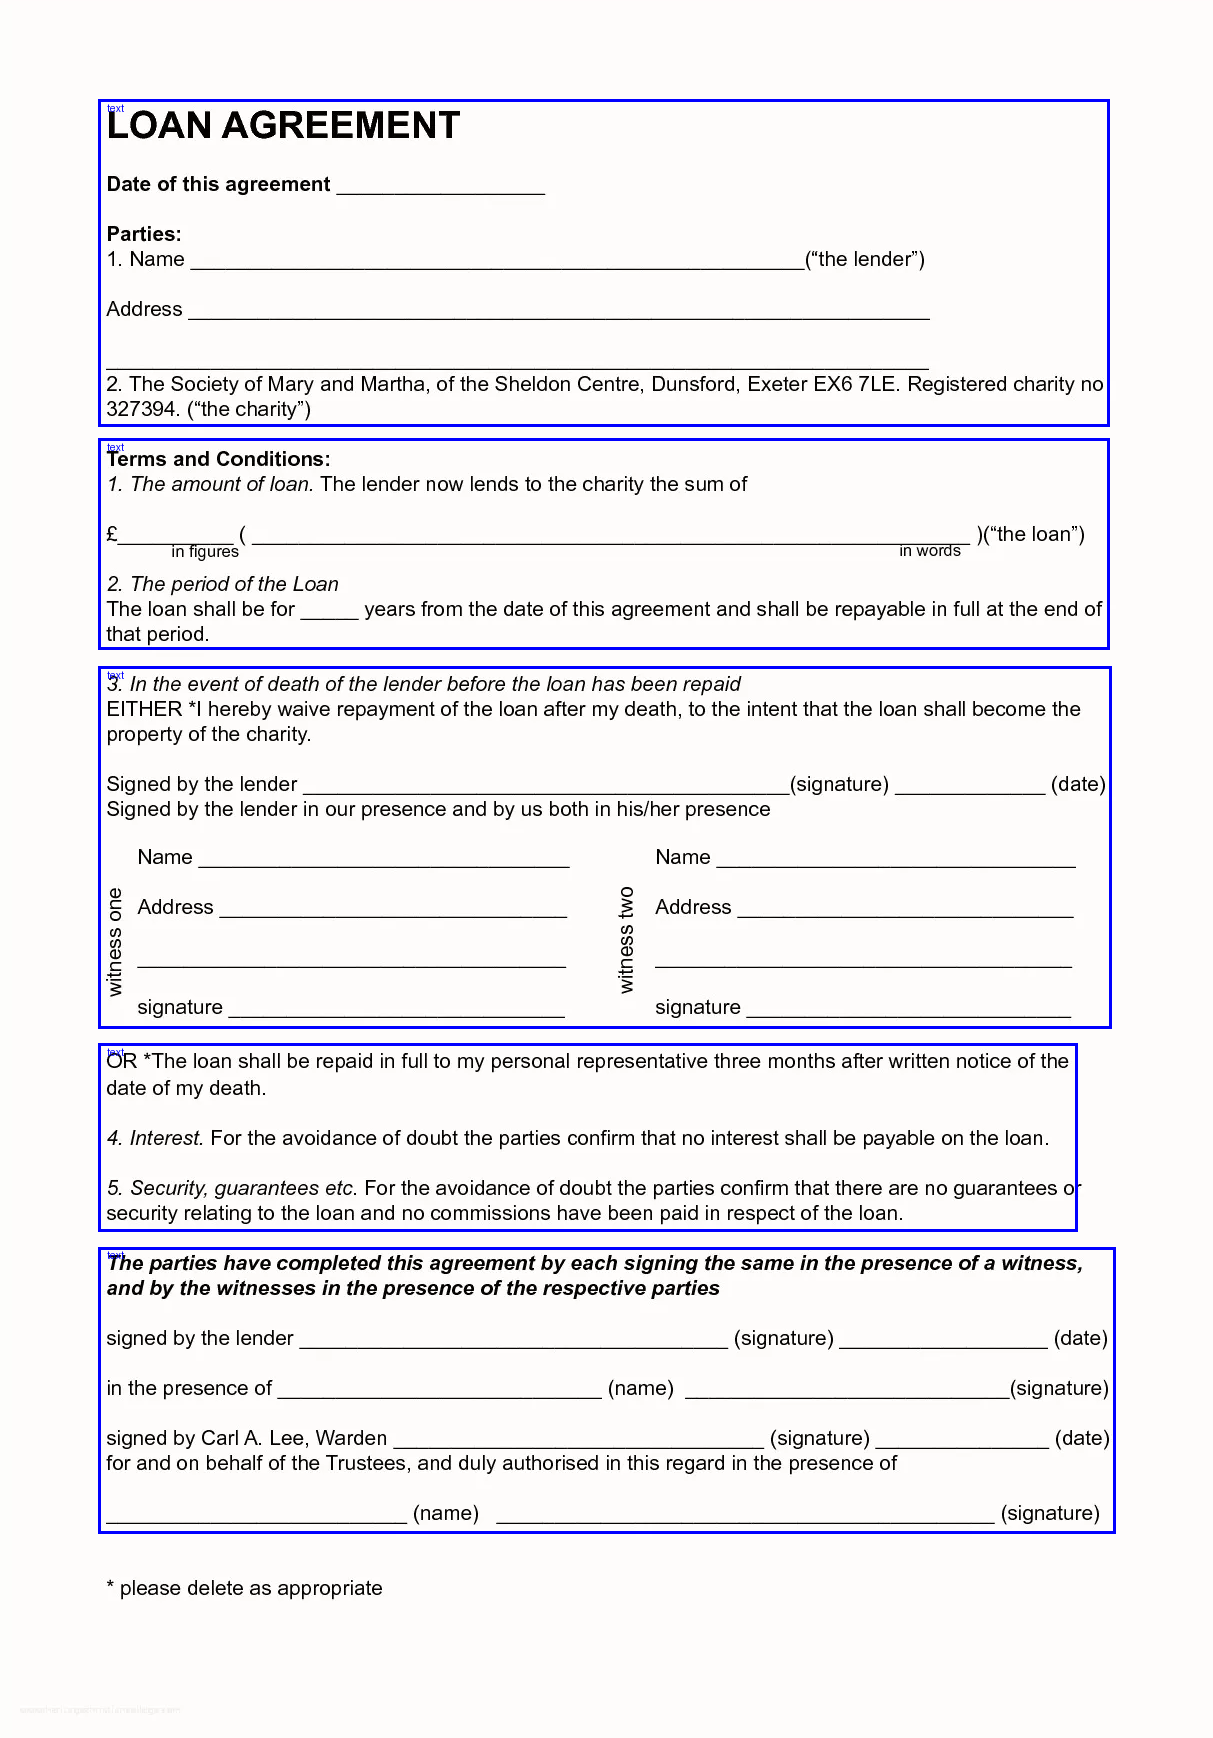

In [33]:
output_image = image
w, h = output_image.size
scale = 800 / max(w, h)
scale = 1
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
p = draw_ocr_bboxes(output_image, parsed_answer['<OD>'], scale=1) 